# **任务6 卷积回归 CNN - Regression**

## 1. **定义模型**

图像回归任务以边界框回归为例，对模型训练要求较高，可以适当增加深度

In [46]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(CNN, self).__init__()
        self.img_encoder = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
        )
        self.flatten = nn.Flatten()

        self.output_layer = nn.Linear(2048, output_dim)

    def forward(self, x):
        x = self.img_encoder(x)
        x = self.flatten(x)
        x = self.output_layer(x)
        return x

## 2. **数据生成**

边界框回归可以让模型直接输出左上角右下角的x,y坐标，一共是4个值，这种方法由于图像一开始需要变形到相同大小，可能导致坐标映射关系和原图像对应不上，需要额外的处理逻辑。

改良方法是使用 x坐标 / 图像宽度， y坐标 / 图像高度 的比值作为输出，这种比例化的数值能在任何缩放和变形下发挥作用。

但更常用的方法不是使用对角坐标，而是使用中心坐标和**边界**框宽度和高度，同样要与**图像**宽高的做比值处理，这种处理方式有助于模型理解目标的大小与边界框的大小的关系。

为了方便测试的时候展示边界框框选效果，增加了 `get_all_img` 参数方便给测试集展示，不然需要将张量反归一化会比较麻烦。




输入数据形状: torch.Size([1024, 3, 128, 128])
输入批次数量: 8 	批次形状: torch.Size([128, 3, 128, 128])
标签数据形状: torch.Size([1024, 4])
输入批次数量: 8 	批次形状: torch.Size([128, 4])


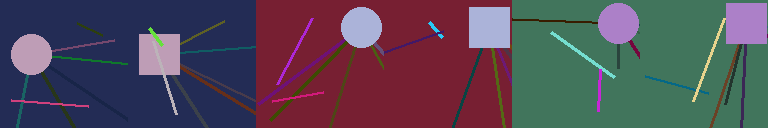

In [47]:
import random
from PIL import Image, ImageDraw
import torchvision.transforms as transforms

def get_data(data_size, img_size, get_all_img=False):
    train_images = []
    # 用于存储对应类别标签的列表
    train_labels = []
    show_img_list = []
    for x in range(data_size):
        b_col = (random.randint(0, 120), random.randint(0, 120), random.randint(0, 120))
        mid_loc = (random.randint(20, img_size-20), random.randint(20, img_size-20))
        r = 20
        loc_0, lod_1 = (mid_loc[0]-r, mid_loc[1]-r), (mid_loc[0]+r, mid_loc[1]+r)
        file_col = (random.randint(120, 255), random.randint(120, 255), random.randint(120, 255))

        image0 = Image.new('RGB', (img_size, img_size), b_col)
        image1 = Image.new('RGB', (img_size, img_size), b_col)

        draw0 = ImageDraw.Draw(image0)
        for _ in range(5):
            draw0.line([mid_loc, (random.randint(0, 255), random.randint(0, 255))],
                       fill=(random.randint(0, 120), random.randint(0, 120), random.randint(0, 120)), width=3)
        draw0.ellipse((loc_0, lod_1), fill=file_col)
        for _ in range(2):
            draw0.line([(random.randint(0, img_size), random.randint(0, img_size)), (random.randint(20, img_size - 20), random.randint(20, img_size - 20))], fill=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), width=3)

        draw1 = ImageDraw.Draw(image1)
        for _ in range(5):
            draw1.line([mid_loc, (random.randint(0, 255), random.randint(0, 255))],
                       fill=(random.randint(0, 120), random.randint(0, 120), random.randint(0, 120)), width=3)
        draw1.rectangle((loc_0, lod_1), fill=file_col)
        for _ in range(2):
            draw1.line([(random.randint(0, img_size), random.randint(0, img_size)), (random.randint(20, img_size - 20), random.randint(20, img_size - 20))], fill=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), width=3)

        loc_0, lod_1 = (mid_loc[0] - r - 10, mid_loc[1] - r - 10), (mid_loc[0] + r + 10, mid_loc[1] + r + 10)
        mid_x, mid_y = abs(lod_1[0] + loc_0[0]) / 2 / img_size, abs(lod_1[1] + loc_0[1]) / 2 / img_size
        w_x, h_y = abs(lod_1[0] - loc_0[0]) / img_size, abs(lod_1[1] - loc_0[1]) / img_size

        if len(show_img_list) < 6 or get_all_img:
            show_img_list.append(image0)
            show_img_list.append(image1)

        # 组合变换操作
        transform = transforms.Compose([
            transforms.ToTensor(),
            # 归一化操作，使用上面定义的均值和标准差
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        image0 = transform(image0)
        train_images.append(image0)
        train_labels.append([mid_x, mid_y, w_x, h_y])

        image1 = transform(image1)
        train_images.append(image1)
        train_labels.append([mid_x, mid_y, w_x, h_y])

    print()
    # 转换为张量
    train_images, train_labels = torch.stack(train_images), torch.tensor(train_labels)
    return train_images, train_labels, show_img_list

# 划分批次
def split_batch(data, batch_size):
    # 核心操作：沿第一个维度（dim=0）分割，保留后续所有维度
    split_tensors = torch.split(data, batch_size, dim=0)
    # 转为列表返回（torch.split返回tuple，列表更易操作）
    return list(split_tensors)

# 训练数据
img_size = 128
batch_size = 128
train_x, train_y, show_img_list = get_data(512, img_size)
train_x_batch = split_batch(train_x, batch_size)
train_y_batch = split_batch(train_y, batch_size)
# 验证数据
val_x, val_y, _ = get_data(128, img_size)
# 测试数据
test_x, test_y, test_img = get_data(6, img_size, get_all_img=True)
print('输入数据形状:', train_x.shape)
print('输入批次数量:', len(train_x_batch), '\t批次形状:', train_x_batch[0].shape)
print('标签数据形状:', train_y.shape)
print('输入批次数量:', len(train_y_batch), '\t批次形状:', train_y_batch[0].shape)

m = 0
combined = Image.new('RGB', (img_size*len(show_img_list), img_size))
for img in show_img_list:
    combined.paste(img, (m, 0))    # 把a贴到画布左侧
    m += img_size
combined

## 3. 模型训练

### 3.1 实例化模型、损失函数、优化器

本次任务虽然是一个经典的回归问题，所以也可以使用均方误差损失 `nn.MSELoss()`。

由于图像的计算比较复杂，所以通常需要使用显卡并行计算，使用 `device = torch.device("cuda" if torch.cuda.is_available() else "cpu")` 来判断显卡的cuda设备是否可用，然后使用 `to` 方法将数据和模型全都转到cuda上计算.

数据和模型的设备必须同步，不然会报错。

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(3, 4, 32).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

### 3.2 **迭代训练**

In [49]:
epochs = 50
for epoch in range(epochs):
    loss = None
    for i in range(len(train_x_batch)):
        x = train_x_batch[i].to(device)
        y = train_y_batch[i].to(device)
        model.train()
        # 前向传播，得到预测值
        output = model(x)
        # 计算损失
        loss = criterion(output, y)
        # 梯度清零，因为在每次反向传播前都要清除之前累积的梯度
        optimizer.zero_grad()
        # 反向传播，计算梯度
        loss.backward()
        # 更新权重和偏置
        optimizer.step()

    val_x = val_x.to(device)
    val_y = val_y.to(device)
    model.eval()
    output = model(val_x)
    val_loss = criterion(output, val_y).item()

    # 更改验证逻辑为适合分类任务的准确率和召回率
    if (epoch + 1) % 10 == 0:
        print(f'[epoch {epoch+1}]loss:', loss.item())
        print(f'\t val loss:', val_loss)


[epoch 10]loss: 0.002949906513094902
	 val loss: 0.0030173752456903458
[epoch 20]loss: 0.001213251380249858
	 val loss: 0.0011763176880776882
[epoch 30]loss: 0.00035300865420140326
	 val loss: 0.0005895684007555246
[epoch 40]loss: 0.00016036377928685397
	 val loss: 0.00025646487483754754
[epoch 50]loss: 0.00011177378473803401
	 val loss: 0.00019409040396567434


### 3.3 **测试模型**

使用 `model.eval()` 将模型改为测试模式，避免自动的梯度计算增加额外的计算量。

使用 `torch.argmax()` 将概率得分向量转换为类别索引。

输入数据: torch.Size([3, 128, 128])
目标结果: [0.7265625, 0.734375, 0.46875, 0.46875]
预测结果: [0.7331733703613281, 0.7486175298690796, 0.4692642092704773, 0.4729379117488861]
输入数据: torch.Size([3, 128, 128])
目标结果: [0.7265625, 0.734375, 0.46875, 0.46875]
预测结果: [0.741837739944458, 0.75618577003479, 0.46238574385643005, 0.4705409109592438]
输入数据: torch.Size([3, 128, 128])
目标结果: [0.3828125, 0.5390625, 0.46875, 0.46875]
预测结果: [0.37925365567207336, 0.5132136344909668, 0.4690248966217041, 0.45550310611724854]
输入数据: torch.Size([3, 128, 128])
目标结果: [0.3828125, 0.5390625, 0.46875, 0.46875]
预测结果: [0.37001940608024597, 0.522851824760437, 0.45412856340408325, 0.4526717960834503]
输入数据: torch.Size([3, 128, 128])
目标结果: [0.1640625, 0.1875, 0.46875, 0.46875]
预测结果: [0.21499237418174744, 0.2304612100124359, 0.45888030529022217, 0.4611267149448395]
输入数据: torch.Size([3, 128, 128])
目标结果: [0.1640625, 0.1875, 0.46875, 0.46875]
预测结果: [0.17723038792610168, 0.19929073750972748, 0.4664030075073242, 0.45911741256713867]
输入数据: 

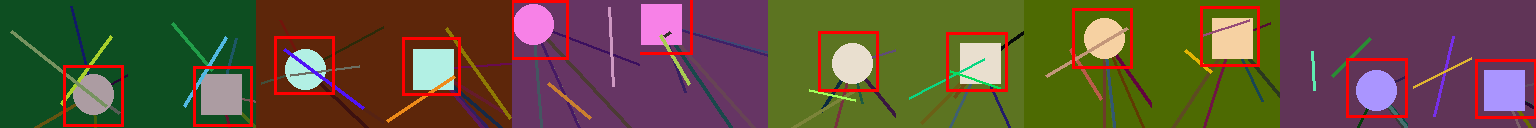

In [52]:
model.eval()
test_x = test_x.to(device)
output = model(test_x)

m = 0
test_combined = Image.new('RGB', (img_size*len(test_img), img_size))
for i in range(len(test_x)):
    img = test_img[i]
    draw = ImageDraw.Draw(img)

    mid_x, mid_y, range_w, range_h = output[i].to('cpu').tolist()

    loc_x0 = mid_x * img_size - range_w * img_size / 2
    loc_y0 = mid_y * img_size - range_h * img_size / 2
    loc_x1 = mid_x * img_size + range_w * img_size / 2
    loc_y1 = mid_y * img_size + range_h * img_size / 2

    draw.rectangle(((loc_x0, loc_y0), (loc_x1, loc_y1)), outline=(255, 0, 0), width=3)

    test_combined.paste(img, (m, 0))    # 把a贴到画布左侧
    m += img_size
    print('输入数据:', test_x[i].shape)
    print('目标结果:', test_y[i].to('cpu').tolist())
    print('预测结果:', output[i].to('cpu').tolist())

test_combined